In [1]:

import requests

from concurrent.futures import ThreadPoolExecutor

from pyquery import PyQuery as pq

import json

import threading

import time


def get_list_page_url(city):

    start_url = "https://{}.lianjia.com/ershoufang".format(city)
    headers =  {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
    }
    try:
        response = requests.get(start_url, headers=headers)
        # print(response.status_code, response.text)
        doc = pq(response.text)
        total_num =  int(doc(".resultDes .total span").text())
        total_page = total_num // 30 + 1
        # 只能访问到前一百页
        if total_page > 100:
            total_page = 100

        page_url_list = list()

        for i in range(total_page):
            url = start_url + "/pg" + str(i + 1) + "/"
            page_url_list.append(url)
            #print(url)
        return page_url_list

    except:
        print("获取总套数出错,请确认起始URL是否正确")
        return None


detail_list = list()

# 需要先在本地开启代理池
# 代理池仓库: https://github.com/Python3WebSpider/ProxyPool
def get_valid_ip():
    url = "http://localhost:5000/get"
    try:
        ip = requests.get(url).text
        return ip
    except:
        print("请先运行代理池")


def get_detail_page_url(page_url):
    global detail_list
    headers =  {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
        'Referer': 'https://bj.lianjia.com/ershoufang'
    }

    try:
        response = requests.get(page_url,headers=headers,timeout=3)
        doc = pq(response.text)
        # broswer.get(page_url)
        # print(page_url)
        # doc = pq(broswer.page_source)
        i = 0
        detail_urls = list()
        for item in doc(".sellListContent li").items():
            i += 1
            if i == 31:
                break
            child_item = item(".noresultRecommend")
            if child_item == None:
                i -= 1
            detail_url = child_item.attr("href")
            detail_urls.append(detail_url)
        return detail_urls
    except:
        print("获取列表页" + page_url + "出错")

lock = threading.Lock()

def detail_page_parser(res):
    global detail_list
    detail_urls = res.result()
    if not detail_urls:
        print("detail url 为空")
        return None
    headers =  {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
        'Referer': 'https://bj.lianjia.com/ershoufang'
    }
    for detail_url in detail_urls:
        try:
            response = requests.get(url=detail_url, headers=headers,timeout=3)
            #print(response.status_code)
            detail_dict = dict()
            doc = pq(response.text)
            unit_price = doc(".unitPriceValue").text()
            unit_price = unit_price[0:unit_price.index("元")]
            title = doc("h1").text()
            area = doc(".areaName .info a").eq(0).text().strip()
            url = detail_url
            detail_dict["title"] = title
            detail_dict["area"] = area
            detail_dict["price"] = unit_price
            detail_dict["url"] = url

            detail_list.append(detail_dict)

            print(unit_price, title, area)

        except:
            print("获取详情页出错,换ip重试")
            proxies = {
                "http": "http://" + get_valid_ip(),
            }
            try:
                response = requests.get(url=detail_url, headers=headers, proxies=proxies)
                #print(response.status_code)
                detail_dict = dict()
                doc = pq(response.text)
                unit_price = doc(".unitPriceValue").text()
                unit_price = unit_price[0:unit_price.index("元")]
                title = doc("h1").text()
                area = doc(".areaName .info a").eq(0).text().strip()
                url = detail_url
                # 已下架的还会爬取，但是没有价格
                if len(unit_price)>0:
                    detail_dict["title"] = title
                    detail_dict["area"] = area
                    detail_dict["price"] = unit_price
                    detail_dict["url"] = url

                    detail_list.append(detail_dict)

                    print(unit_price, title, area)
            except:
                print("重试失败...")


def save_data(data,filename):
    with open("C:/c++/nj.json", 'w', encoding="utf-8") as f:
        f.write(json.dumps(data, indent=2, ensure_ascii=False))

def main():
    # cq,cs,nj,dl,wh,cc
    city_list = ['nj']
    for city in city_list:
        page_url_list = get_list_page_url(city)

        # pool = threadpool.ThreadPool(20)
        # requests = threadpool.makeRequests(page_and_detail_parser, page_url_list)
        # [pool.putRequest(req) for req in requests]
        # pool.wait()

        p = ThreadPoolExecutor(30)

        for page_url in page_url_list:
            p.submit(get_detail_page_url, page_url).add_done_callback(detail_page_parser)
        # 这里的回调函数拿到的是一个对象。
        # 先把返回的res得到一个结果。即在前面加上一个res.result(),这个结果就是get_detail_page_url的返回
        p.shutdown()

        print(detail_list)

        save_data(detail_list, city)

        detail_list.clear()

if __name__ == '__main__':
    old = time.time()
    main()
    new  = time.time()
    delta_time = new - old
    print("程序共运行{}s".format(delta_time))



24980 南北通透三房 16年下半年精装修 装修保养不错 浦口
26775 东郊小镇第四街区精装2房，户型比较大，带电梯。 江宁
31941 集庆门大街 南苑 台园 中间楼层 配套成熟 建邺
52142 新上新城市广场挑高户型，房龄新，带电梯。 鼓楼
32401 河西万达金鹰 茶南明清园2000年 南北通透 精装修 建邺
47936 一楼带四十平院子，单位自己的房子，有物业，有车位 鼓楼
24590 拎包入住，有钥匙，税费少，业主诚售 江宁
37944 天元西路 中锐星湖名邸 开发商精装修 南北通透四房 江宁
2588229045 景枫太阳城竹山路站武夷绿洲品兰苑精装两房 江宁
 南方花园瑞阳居 双龙大道地铁口180米 刚需过渡单室套 江宁
40845 低总价的两室一厅 边户采光好 适合刚需过渡 玄武
33769 满两年 房龄新 南北通透 银城物业 精装修 雨花台
35390 南北通透 精装修 郑和公园 常府街 诚心出售 秦淮
32439 经典户型 精装三房 南北通透 小区中间 随时看房 建邺
25625 此房户型方正 交通出行便利 业主诚心出售 江宁
38576 五老村 大行宫 精装修 双南中间楼层 秦淮
27960 房屋位于较高楼层 总价低 适合刚需年轻人 鼓楼
29564 此房南北通透，楼层位置佳，采光无遮挡，业主诚心卖！ 江宁
24527 玄武 小区环境好 此房满五年 采光充足 南北通透 玄武
33099 长乐路 琵琶小区 夫子庙景区 双南小两房 急售 秦淮
22545 九乡雅苑 地段好 环境很好 江宁
37884 优质三房，精装修 低楼层；带院子！ 秦淮
28071 月牙湖 紫金山 仁恒物业 中间楼层错层户型 秦淮
27898 南方花园 纯地铁口 刚需两房 户型方正楼层好 江宁
32637 双南一北，户型方正，采光无遮挡，生活便利 秦淮
33453 双南一北 中间楼层 满五年 业主诚售 近南京一中 秦淮
55725 金陵湾 精装带地暖中 央空调 房型方正 南北通透格局 鼓楼
20474 业主诚心出售，大三房，满五唯一 税少，看房子方便！ 浦口
25569 满五唯一，有钥匙看房方便，精装修拎包入住 浦口
32523 精装 户型工整 视野开阔 采光好 苜蓿园 光华路 秦淮
28000 边户带飘窗 小高层电梯房 环境好 交通便利 有钥匙 秦淮
23331 瀛洲

27139 此房满两年 采光刺眼 精装修 楼层好 物业好 交通好 浦口
26662 省中医院 汉中门地铁 低总价两房 满五年 业主诚售 秦淮
55375 位于2楼，两室朝南，家电都有。 秦淮
47900 凤凰街84号 精装修 采光好 南北通透 汉中门地铁600米 鼓楼
22882 双卧朝南 中间楼层 采光充足 视野好 满五唯一 浦口
28192 朝南单室套楼层高视野好看房需戴墨镜 江宁
34109 此房楼层低，有院子，东边户亮堂 鼓楼
23385 南方花园瑞阳居 朝南两居室 精装修 满五年 急售 江宁
43083 阅城一期景观房 高楼层 采光充足 雨花台
17830 翠屏城 2室1厅 122.7万 江宁
27976 满五年 教师房改房 户型方正 双卧朝南 秦淮
49491 两房朝南 居家精装修 2000年电梯房 可直接拎包入住 秦淮
41245 业主诚售 南北通透 拎包入住 看房方便 秦淮
36492 南北通透格局 视野开阔 诚心卖房 看房方便 秦淮
30048 文体路 南苑 话园 南北两房 总价低 全明户型 建邺
33067 钟山晶典两房 采光好 户型好 看房方便 栖霞
25286 地铁口 双南双北 通透明亮 婚装 拎包入住 栖霞
30849 南湖公园，中间楼层，户型方正，居家两房。 建邺
21400 金地自在城第二街区 3室2厅 222万 雨花台
32787 视野好，采光充分，业主诚心卖房 秦淮
24881 安德门 雨花南路 邓府山村 南北全明两房 雨花台
22798 华菁水苑 2房满2年精装修随时看房 江宁
24470 满两年 东边户 位置好不临高速 价格可谈 雨花台
50072 5.2米复式挑高 秦淮河畔 带电梯 建邺
30030 此房南北通透，楼层位置佳，采光无遮挡。 江宁
20442 降价急卖，2房精装修，电梯中高楼层，采光视野好 江宁
16578 翠屏城 大三房 南北通透户型 满两年 随时看房 江宁
31553 铁心桥 复式精装修 万科品牌物业 中间楼层 雨花台
25191 天润城小三房 满五年 地铁口 点进来就是惊喜 浦口
34302 黑龙江路 许府巷 98年房龄新小区安静 鼓楼
72613 交通方便 低楼层 户型方正 有小区 鼓楼
38197 腾达雅苑 2室2厅 338万 建邺
66306 新河一村 楼层好 适合老人带孩子居住 鼓楼
37448 房

exception calling callback for <Future at 0x167035cf6a0 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 80, in create_connection
    raise err
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 70, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", 

exception calling callback for <Future at 0x1670356ab38 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 80, in create_connection
    raise err
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 70, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", 

30819 有产权车位 带地下室 不临火车马路 南北通透 带露台 秦淮
25339 明月港湾 大两房 视野炸裂全明 电梯 无个税 江宁
83774 常府街 游府新村 三室一厅 户型方正 采光好 秦淮
54237 诚心出售， 满五唯一，户型方正，300米地铁 建邺
请先运行代理池
30651 带车位，带大露台，养花，种草，晾晒，是一个很好选择 鼓楼
请先运行代理池
25384 明月港湾 户型方正 看房方便 江宁
请先运行代理池
请先运行代理池
45804 中间楼层 南师大房改房 不临街 采光好 户型方正 鼓楼
39328 南湖 润花园 采光好 视野佳 电梯三房交通便利配套齐全 建邺
22544 银亿东城十二街区，满两年精装修，198万 江宁
39932 河西万达 金鹰坐临 双卧朝南 满二年 婚装 建邺
31497 中高楼成 精装修 无遮挡 满五年唯一 江宁
32216 满五年 装修棒 交通便利 采光充足 雨花台
32796 南部新城 双南一北电梯三房 小区中间位置 采光好 秦淮
35159 五老村三条巷小杨村红花地常府街双南全明户型满五 秦淮
30462 一楼带院子 有钥匙随时看房 交通便利 配套成熟 江宁
38938 南北通透双阳台 采光无遮挡 三层隔音玻璃 一梯两户 江宁
23537 瀛洲湾电梯大两房 业主诚心出售 看房方便 江宁
21232 此房满两年，配套设施完善，交通便利。 江宁
29823 满五年精装修南北通透小区已经出新2001年商品房 玄武
27987 精装三房 中上楼层 位置好 采光充足 配套设施完善 栖霞
54272 洪武路 户部街 延龄巷 精装三房 一楼带院子 不临街 秦淮
36245 凯博酒店 拎包入住 带电梯环境好 玄武
23720 户型好 价格低 位置佳 业主急卖 江宁
32421 虹苑新寓，满五年唯一，采光充足，业主诚心卖 建邺
78609 新河二村精装单室套，采光无遮挡 鼓楼
25158 世纪东山婚装小三房 户型方正 南北通透 带车位 江宁
42040 小区中间 2015年30万精装 小高层电梯房 满两年采光佳 建邺
21411 满五唯一税费少，南北通透户型好，总价低 浦口
21312 新城保利天地 翔宇路北 精装交付 业主诚售 江宁
29305 楼层好，视野开阔，湖景房，看房方便 江宁
19778 江岸水城 两室 满五年 出行便捷 适

25532 南部新城 大明路 2居室 南北通透 看房方便 秦淮
27875 民水民电 通燃气 70年产权 朝南 高楼层 采光好 秦淮
31855 秦淮区夫子庙地区，生活方便，交通便利，舒适三房 秦淮
40876 珠江路 浮桥 成贤街 交通便利 采光充足 玄武
34285 中华门旁 雨花苑 满五年 婚装房，业主诚心卖 雨花台
35601 中间楼层 双南双北 汉中门大街 看房方便 建邺
21742 精装修，满两年，采光充足，户型方正，出行便利 江宁
28430 楼层好 装修好，户型方正适宜。 鼓楼
32858 万科金色里程 2室1厅 230万 雨花台
22096 威尼斯四街区，南北通透三房，楼层好，视野好 浦口
22671 简装毛坯自己装修 电梯中间楼层 小区配套成熟 江宁
84388 三楼采光无遮挡 满两年不唯一 育才公寓 鼓楼
25595 弘阳三区 纯毛坯 南北通透 业主诚心 有钥匙看房方便 浦口
28247 南北通透，采光好，出行方便，装修好拎包入住 秦淮
25113 景明佳园 精装两室 全明双南 无收益金 雨花台
33780 夫子庙商圈 中间楼层 小三房 装修好 拎包入住 满五年 秦淮
25873 满五唯一税费少 配套成熟 1号线河定桥地铁站 江宁
26029 岔路口 明月港湾 带暖气南北通透 小三房 江宁
36449 闹中取静 采光好 随时可看 出行便利 秦淮
30589 景枫太阳城竹山路站武夷绿洲品兰苑精装两房 江宁
38018 此房满五唯一，南北通透，户型方正，业主诚心出售。 鼓楼
27785 店长推荐房源 85平双阳台户型 满二年 精装修 诚售 江宁
16127 宝驰景秀苑 3室2厅 190万 江宁
45039 河西奥体 满五年 西边户 不靠高架 小区中间位置 建邺
26971 满五年 交通便利 视野开阔 采光无遮挡 明厨明卫 秦淮
30015 鸿信清新家园 环境好 带电梯 采光无影响 玄武
69445 此房满五年无增值税和个税，采光无遮挡，户型方正 鼓楼
64308 建邺奥体仁恒品质地暖中胜新城新地拎包入住 建邺
27832 空调加全屋地暖 精装三房，南北向通透，随时可以看房 栖霞
37720 银城物业小区环境好，精装业主自住保养很好，拎包入住 江宁
25090 武 夷 水 岸 家 园 满 两年 精装修 拎包入住 江宁
28317 康润园 安德门双地铁

43943 湖南路 高档小区 户型规整 生活方便 配套完善交通便利 鼓楼
28104 此房精装修 楼层好 有车位 采光棒 江宁
27922 东郊小镇第四街区 2室1厅 119万 江宁
25697 看房方便 总价低单室套 采光无遮挡 交通便利 秦淮
23959 楼层适中，交通便利，视野开阔，采光充足 雨花台
26075 天润城第十二街区 2室2厅 188万 浦口
56215 新街口 钟英 小区环境好 满五年 全明三房 秦淮
35352 丹佛小镇70年产权 5米4挑高住宅 正南户型 采光好 江宁
27836 保利梧桐语花园 3室2厅 228万 江宁
21653 中间楼层 东边户 采光无影响 居家精装两房 浦口
33156 三山街地铁 来凤新村双南两房 满五年 秦淮
60588 凤凰花园城 双南卧室 满五年 中间楼层 凤凰西街 鼓楼
48939 满五年唯一 南北通透 采光刺眼 配套齐全 人车分流 鼓楼
32452 精装修 汉中门大街 看房方便 配套完善 建邺
29647 东渡国际青年城二房朝南客厅带小阳台 江宁
40940 港龙花园电梯大三房 低楼层采光不挡 随时看房 鼓楼
28147 幕府佳园 大三房 可建院子 采光好 有钥匙 鼓楼
29424 卫岗25号 不临街中间楼层 全明边户两房 下马坊地铁 玄武
31774 新街口明瓦廊三元巷精装修拎包直接住 秦淮
34314 应天大街 秦虹 满五年 居家装修三房 秦淮
37823 南北通透 视野开阔 大光路 秦虹 秦淮
25150 高尔夫西花园 4室2厅 420万 江宁
31282 正规小区有物业 非顶楼 看房有钥匙 鼓楼
25450 旭日爱上城星岛园大三房 纯毛坯可自由发挥 浦口
31597 十字街70号 2室1厅 185万 玄武
23868 潭桥公寓南园 3室2厅 215万 江宁
40318 东边户 三阳台 拎包入住， 诚心出售， 南北通透 玄武
39768 楼层好 精装修 满五唯一 南北通透 建邺
47487 夫子庙商圈 小区环境好 商品房 改善 南北通透 秦淮
21497 天地新城大四房 楼层好 有自带人工湖 江宁
60652 凤凰花园城静幽园 3室2厅 570万 鼓楼
43430 价格含产权车位 三房 生活交通便利 闹中取静 诚心出售 鼓楼
31556 大明路 南部新城 1室1厅 刚需过渡房 采光好 户型正 秦淮
2

27119 邓府山村 2室1厅 160万 雨花台
24149 70年产权商品房 总价低 实用面积大 通燃气 江宁
21196 南北通透三房 中间楼层 满五唯一 采光充足 素质业主 浦口
33165 秦虹 洪家园 大明路 南部新城 良城美景家园 小三房 秦淮
28960 竹山路 地铁 武夷绿洲 品兰苑 毛坯 小区新 江宁
30209 此房满两年 采光好 户型方正 交通方便 小区环境优美 浦口
23884 桥北 威尼斯 满五 毛坯 带电梯 浦口
34443 顶跃带露台 采光好 视野开阔 南北通透 户型方正 建邺
45055 儒林雅居夫子庙商圈小区环境好采光不挡三房 秦淮
34377 中航樾府 满两年 精装 无贷款 江宁
54564 清江西苑 人车分流 楼层好 采光充足 鼓楼
25364 满五年 南北通透 楼层好 户型方正 生活配套完善 江宁
37042 满二精装好房，业主保养的很好，诚心出售。 栖霞
62538 总价Di 楼层低 毛坯 地铁近 看房方便 鼓楼
31230 一楼带院子 适合居 家 养 老 雨花台
51230 总价低单室套 居家楼层 采光好 居家陪读 交通方便 鼓楼
62678 中海好户型 入户花园 采光不挡 建邺
31031 沿河四村 南北通透 采光不挡 两房 满五年无增值说 建邺
30401 秦虹 南部新城 精装修 南北通透 电梯房 秦淮
19191 江北新区柳洲东路威尼斯水城 花园洋房 南北通透 满五 浦口
24211 金贸新村 工商房改房 双南户型 莫愁湖公园 水西门大街 建邺
29157 江南名府新上顶跃 户型方正 南北通透 交通便利带露台 建邺
31215 百家湖一楼带院子 万科物业 环湖景观 江宁
18182 大厂街道低总价小三房中间楼层近地铁集中供暖费用低 六合
26569 中间位置 南北通透 采光无遮挡 户型方正 月牙湖畔 秦淮
56429 中间楼层 东边户 采光好 满五唯一 鼓楼
42520 美丽嘉园 满二 无增值税 交通便利 配套齐全 建邺
60953 全明格局 南北通透 阳光和蔼 户型方正 冬暖夏凉 鼓楼
24461 滨江花园西园 满五年唯一 采光无遮挡 业主诚售 鼓楼
24562 科嘉花园 户型方正 多层使用面积大 江宁
24524 经典挑高 居家精装 保养全新 诚心急售 江宁
26298 天坛新村 3室1厅 193万 秦淮
202

exception calling callback for <Future at 0x16703639d30 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 80, in create_connection
    raise err
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 70, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", 

24391 此房满五唯一 南北通透 户型方正 采光足 得房率高 栖霞
29453 两房朝南 厅朝南 居家装修 高楼层 采光好 晾晒方便 江宁
30516 21世纪假日花园 3室2厅 300万 江宁
26719 三房朝南 不靠主路 小区依山傍水 环境很好 带电梯 江宁
请先运行代理池
26741 店长推荐好房 满五唯一 南北通透 精装自住 江宁
32708 采光充足 交通便利 电梯直达 夫子庙景区 秦淮
36785 欢迎带看老虎头小区，多多带看，业主诚心 秦淮
35877 满五年无增值税 中间楼层 业主诚心出售 秦淮
60491 树人、树人、满五唯一、生活交通便利 鼓楼
45406 30㎡院子 满五年，双南一北，小区已经完成出新 鼓楼
21501 业主急售 单价低 可以做阁楼 看房方便有钥匙 玄武
22577 小区环境好，户型方正，业主诚心出售 浦口
28884 文化名园 3室1厅 339万 江宁
51201 新街口03年电梯直达 3梯6户 全明 居家拎包住 秦淮
27479 此房满五唯一，少个税，精装修大三房 江宁
33907 架空一楼 精装修单室套 户型方正 出行方便 秦淮
25852 保利梧桐语花园南北通透三房 精装 楼栋位置好 诚卖 江宁
39353 东方天郡西区 栖霞建设物业 三房两卫 南北通透 栖霞
26989 颐秀居电梯精装三房，南北通透全明户型，采光无遮挡 江宁
28675 岔路口明月港湾 边户三房 带一大院子 满两年 有钥匙 江宁
31122 南站商圈 南方花园 银城物业 地铁口 总价低 小三房 江宁
29666 河西万达 金鹰欧尚 茶南商圈 福园小区 中间楼层 建邺
38747 经典三房 户型方正 位置好 楼层好 鼓楼
22198 此房一楼东边户带有大院子 满五唯一 栖霞
20968 满2年 中间楼层 南北通透 业主诚心出售 采光好 浦口
91845 双南户型 中间楼层 房龄新 配套齐全 交通便利 鼓楼
25743 紫金山脚下 楼层好 南北通透 户型方正 采光充足 玄武
21998 江岸水城 地铁刚需精装两房 满五唯一低总价 浦口
33713 电梯顶跃 不临高架 精装修 东边户 采光好 满五 建邺
29816 户型方正 南北通透 采光好 视野无遮挡 带储藏室 江宁
47905 满五唯一无户口 南北通透 采光充足无遮挡 小区干净 秦淮
58751 奥

exception calling callback for <Future at 0x167036499b0 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 80, in create_connection
    raise err
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 70, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", 

 集庆门大街 秦淮河畔 润花园小区 电梯三房 精装修 建邺
25780 旭日上城三区 满两年 客厅复式改3房 采光好 浦口
35386 户型方正 业主诚心卖房 户口、随时可签 栖霞
29319 南北通透 格局好 采光充足 生活配套齐全 浦口
22176 满五年唯一住房 婚装2房 双南 近柳州东路地铁口 浦口
27333 两房朝南 客厅朝南 刚需小两房 精装修 拎包入住 江宁
32296 2000年房龄 小区环境好 精装修 南北通透 鼓楼
请先运行代理池
29964 南理工四号门 庆盛园 石林百货 双南户型 中楼层 玄武
42580 满五唯一 精装大两房 南北通透 采光无遮挡 鼓楼
33934 此房满五年唯一，双南一北格局，楼层好，采光充足。 鼓楼
25072 鼓楼区 刚需两房 全明户型 交通便利 房龄新 鼓楼
26537 满五年税费低，楼层高，视野好，采光充足，南北通透 江宁
21417 交通便利，配套设施好，人文环境浓厚，适合居家 江宁
37346 满5年 免增值税 中间楼层 户型方正 产权清晰 鼓楼
27356 此房满2年，交通便利，采光充足。 江宁
25081 双南 毛坯 2012年房龄 玄武区 采光充足 玄武
20385 花港幸福城芙蓉园 3室1厅 178万 栖霞
25349 楼层好，拎包入住，临莫愁湖公园，生活方便。 建邺
25884 标准四房 精装修 采光良好 小区环境优良 江宁
30797 07年房龄 16年自住精装修 带电梯 北望紫金山 栖霞
29476 香榭美颂 品质洋房 配套完善 出行方便 业主诚售 浦口
36239 一梯两户 南北通透格局 户型方正 采光充足 栖霞
35203 1楼带院子 有保安有物业 东边户 全明格局 96年房龄 建邺
23440 居家精装修，拎包住，楼层好有江景 浦口
30417 1楼带个小院子 满2年 装修好 位置好 拎包入住 江宁
29117 满五唯一 四房 四房 精装修 南 北通透 建邺
40432 湖景花园 玄武湖湖景 顶跃有露台 银城物业 玄武
48787 电梯大三房东边户租赁车位精装修满五唯一 鼓楼
94546 西康路 2室1厅 520万 鼓楼
25496 地铁口威尼斯一街区，精装修三房，满五年无个税 浦口
35970 比肩奥体 双地铁 三房两位 楼层好 采光佳 雨花台
29008 南方花园C组团 2室1厅 24

25590 双卧朝南采光好 满五年税费低 南边是幼儿园 无遮挡 江宁
35780 时光大四房，全明户型，银城物业，有车位。 雨花台
21999 精装四房带租赁车位户型方正采光好东门地铁西门菜场 江宁
49995 秦虹 南部新城 2010年品质商品房 总价低 环境好 车位 秦淮
29415 百家湖 万科物业 临湖三房 毛坯 江宁
28206 燕康园 3室1厅 220万 鼓楼
17852 泰来苑 3室2厅 235万 浦口
18064 南北通透三房 中间楼层 采光充足 视野好 浦口
32464 南站商圈 南方花园 经典5.2米挑高 朝东不临街安静舒适 江宁
62959 两房朝南厨卫朝北，户型方正，居家装修，交通便利。 鼓楼
31913 武定门 小心桥东街 饮虹园 江宁路 木匠营 小两房 秦淮
27935 湖西村小区满五唯一两房朝南户型好 建邺
19102 银城蓝溪郡 3室2厅 170万 江宁
33261 阳光广场 电梯 交通便利 配套成熟 鼓楼
34122 地铁电梯房 中间楼层 南北朝向 诚心出售 秦淮
26432 藏龙御景 精装大平层 楼层好 业主诚售 带产权车位 江宁
55588 河西金鹰 金地名京 集庆门地铁口 采光好有装修 建邺
70265 北京东路商圈 兰园小区 低楼层三房 配套成熟 交通便利 玄武
32527 汉中门大街 中间楼层 大三房 交通便利 隔壁莫愁湖 建邺
69045 小面积三房 楼层合适 采光充足 位置好避免噪声影响 鼓楼
17655 高新花苑 4室2厅 238万 浦口
47561 河西万达广场旁精装两房拎包入住 建邺
22858 纬三隧道口 交通出行方便 业主诚心出售 户型明朗 浦口
34461 2006年 双南卧室 边户 带车位 带架空储藏室 秦淮
36222 大行宫 科巷菜场 苏果超市 低总价 厨卫有窗 三条巷 秦淮
34866 婚装房 带大客厅 郑和公园 四五四医院 秦淮
64517 珠江路浮桥纱帽巷蓁巷沙塘园将军巷采光不挡 玄武
20120 家具家电齐全，拎包入住，交通方便。 浦口
27386 满五年 精装修 采光好 电梯房 户型方正 秦淮
20953 马群东 户型方正 采光无遮挡 小区环境优美 江宁
24175 瀛洲湾 3室2厅 249万 江宁
31541 地铁口有多路公交，南湖公园，南湖广场，省二医院 建邺
29000 环境好 生活便

31715 月牙湖 大地建设房改房 满五年 一楼架空采光好 秦淮
29680 小区出新 环境好 精装修 看房方便 秦淮
44296 夫子庙地段 张府园地铁 双南 边户 居家装修 秦淮
28512 中间楼层 南北通透两房 采光充足 户型方正 秦淮
31967 河西万达 金鹰世界 茶南云锦路 户型方正 建邺
29113 中间楼层，视野开阔，采光充足，业主自住装修 江宁
22837 户型方正、南北通透、小三房、采光充足。 江宁
60836 新街口电梯房 08年房龄新 出行便利 配套齐全 秦淮
45565 中海凯旋门 别墅 有院子 可停车 鼓楼
23735 天地新城天琴座 2室2厅 225万 江宁
34549 鼓楼 满五唯一 中间楼层 全明户型 鼓楼
30333 小区中间位置 南北通透 中间楼层 带地下室 秦淮
26593 翠屏国际大三房 精装修 户型方正 采光足 拎包入住 江宁
21724 天祥家园刚需房总价低首付压力小满二 江宁
36318 集庆门大街家乐福超市江南名府满五年唯一大三房低楼层 建邺
29945 居家装修 多层2楼 小区中间位置 东边户 看房方便 江宁
21690 鼓楼 小市商圈 金碧花园 高楼层 采光充足 南北通透 鼓楼
22386 化建一村 3室1厅 168万 栖霞
40909 奥体 中和园 小三房 居家精装修 诚心出售 建邺
25073 秦虹 武定门 大明路 晨光厂房改房 双南 拎包入住 秦淮
27226 满五 拎包入住 低总价 配套齐全 江宁
29371 银城物业，拎包入住，业主诚心出售。精装修两房 江宁
21402 威尼斯水城第十五街区 毛坯 三房 采光充足 浦口
35986 基础设施完善 交通便利 采光好 雨花台
48115 嘉业阳光城一期精装大三房 万科物业 业主置换诚售 建邺
43107 托乐嘉旺邻居 4室2厅 419万 江宁
48517 高楼门 3室1厅 520万 玄武
33504 南方花园C组团 2室1厅 210万 江宁
34076 百家湖正规两房 户型方正 业主诚心出售 采光好 江宁
19266 满两年 南北通透 采光充足 业主诚售 江宁
37896 中华门商圈 双卧朝南精装 满五年唯一 雨花台
29682 客户很着急卖，楼层也好，南北通透 江宁
14543 东郊小镇第三街区 5室2厅 205万 江宁
25624 万科物业 三房 南北

27612 三山街地铁 菱角市 两房朝南 满两年 秦淮
47421 龙江新城市假日 精装电梯三房 采光充足 满五 鼓楼
26478 一楼带南院 大院子 简装 业主诚售 看房有钥匙 浦口
22515 户型方正 离地铁口近 业主卖房诚心 浦口
25028 和燕路小区 3室1厅 230万 栖霞
37137 精装 配套成熟 视野开阔 交通便利 玄武
25584 东井村46号 3室1厅 230万 栖霞
31767 精装四房 东边户 拎包入住 带暖气 双卫 玄武
61152 西家大塘 紧靠科利华 配套成熟 出行方便 玄武
41515 奥体 钟鼎雅居 精装两房 采光充足 配套成熟 满两年 建邺
26749 户型好 楼层好 采光好 小区环境好 浦口
30837 三山街双塘里 单位房改 边户全明 满5唯一中间楼层 秦淮
42835 太平北路 3室1厅 295万 玄武
19318 刚需3房客厅朝南带阳台厨卫全明 江宁
27803 光华路双娜三房 总价低户型公正 交通方便 秦淮
32825 来凤商圈 仙鹤里小区 低楼层户型正 采光好 秦淮
22589 采光充足 视野开阔 交通便利看房方便 浦口
41506 银城东苑 大两房 三开间朝南 户型好 高楼层 玄武
29195 光华路石门坎 精装两房中楼层 满五年户型好 总价低 秦淮
53254 奥体 朗诗南园 边户 全明户型 南北通透 精装三房 建邺
32389 露园 简装单室套 南北通透 中间楼层 建邺
23957 大华榴美颂 精装修三房 保养好 拎包入住 配套完善 浦口
75867 满五唯一 业主诚售 楼层好 全明户型 鼓楼
27383 秦淮河畔 武夷绿洲品兰苑 小区新 配套成熟 江宁
27144 汇金旗林大厦 1室1厅 145万 江宁
22936 威尼斯二街区 毛坯三房 交通便利 看房随时 浦口
27424 侯家桥 3室1厅 230万 秦淮
50639 此房精装修拎包住 满二年 交通便利 生活方便 鼓楼
39027 观音阁 浮桥 珠江路 低楼层 南北通透 价格合适诚心卖 玄武
28425 商品房小区，交通方便，配套成熟 鼓楼
28949 百家湖新空毛坯三房 环境好 户型好 可看湖 江宁
30728 云锦路 茶花里 双南 采光好 满五年 业主诚售 建邺
30299 满五唯一，无贷款无抵押，随时看房,,,, 玄武
21555 天地新城三房两卫

36143 顶跃 精装 地暖 舒适4房 建邺
40214 鼓楼龙江 电梯三房 交通便利 户型方正 鼓楼
39373 地铁4号线 龙江地段 省级机关房改房 3房 南北通透 鼓楼
32034 鼓楼金陵小区商圈精装双南电梯两房 中高楼层 配套成熟 鼓楼
21237 户型好 采光充足 交通便利 配套成熟 江宁
57419 2015年交付商品房 满二 精装拎包即可入住 无限江景 鼓楼
57963 新街口 楼层好 南北通透 全明 小区环境好 秦淮
18861 海润枫景家园 3室1厅 185万 浦口
24934 御道街 石林家居 三房 精装修 满五年 采光好 交通方便 秦淮
27899 满五年唯一 做过平改坡 正规小区可停车 鼓楼
22000 春江新城天隆坊 居家简装 户型方正 大面积三房 雨花台
24105 和燕路小区 双南一北 南北通透 采光好 满五年唯一 栖霞
24586 柳州东路地铁站 燕子矶过江通道 浦口
27728 满五年唯一 楼层好 采光充足 交通便利 浦口
34827 中华门，房子位置方便，老小区配套齐，生活便利 雨花台
27192 明月港湾 一楼带院子 居家精装 户型方正 采光无遮挡 江宁
24909 奥南金地 三开间朝南 三房 雨花台
35187 小区中间位置，户型设计合理，装修保养好 秦淮
71713 户型方正 视野开阔 光线十足 精装 鼓楼
36369 万科金域蓝湾，三期，南北通透，三房，采光无遮挡。 江宁
30551 三山街商圈 南北两房 精装修 拎包入住 秦淮
获取详情页出错,换ip重试
52840 满五唯一 看房方便 边户 精装 楼层好采光不挡 鼓楼
23829 此房满五唯一， 免个税， 精装修，此房为底跃 栖霞
92275 此房满五年唯一，居家精装修保养完好，一楼带院子 鼓楼
30504 建康路 钓鱼巷 龙蟠中路 单室套 装修好 秦淮
23234 纯毛坯，户型方正，交通便利，配套完善。 江宁
27174 九龙湖精装三房满五年，南北通透，带地暖 江宁
37405 精装一楼拎包住，户型采光好，配套成熟。 建邺
68429 科利华 玄武湖旁百子亭小区 精装两房 玄武
38478 夫子庙景区，交通便利，全明户型 秦淮
38369 南部新城 花神湖 南北通透 中间楼层 雨花台
26587 景观位置 南北通透 精装三房 可拎包住 满两年诚售 江宁
49559 

exception calling callback for <Future at 0x1670365f7f0 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 80, in create_connection
    raise err
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 70, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "C:\Users\79826\Anaconda3\lib\site-packages\urllib3\connectionpool.py", 

请先运行代理池
42082 夫子庙景区 装修好 小区环境好 带车位 闹中取静 秦淮
44319 降20万精装新空一拖四空调地暖有露台有储藏室满五唯一 建邺
40599 精装修大户型复式，满五唯一，业主诚心出售 秦淮
24197 科学园片区毛坯电梯大两房全明通透满五唯一 江宁
38832 君临国际 1室1厅 125万 鼓楼
21338 K户型 南北通透两房 总价低 诚心卖 浦口
24609 精装修 通透小三房 满两年 前后无遮挡 浦口
28185 南方花园银城物业 南北通透两房 业主诚心出售 采光好 江宁
25162 百家湖地铁 满两年 湖景房 业主急售 江宁
27372 此房满五唯一 业主诚心卖房，精装修 位置好 江宁
23899 双赢花园 顶跃 有露台 视野好 江宁
35994 秦虹 武定门 2007年商品房 精装三房 生活方便 带车位 秦淮
39054 奥体 高楼层 采光好 满2年 交通便捷 建邺
21207 威尼斯水城第六街区 2室2厅 186万 浦口
26407 环境优美，百家湖大三房，交通便利，业主急售！ 江宁
71248 满五唯一 安静 环境好 牯岭路 民国建筑群 人文素质高 鼓楼
31479 天地花园 2室1厅 198万 秦淮
27281 江北新区纬三隧道口 毛坯两房 采光充足 配套成熟完善 浦口
28945 三房朝南 中上楼层 满两年省大额增值税 江宁
69846 居家装修 一南一北两室 采光充足 位置安静 鼓楼
24057 龙庭水岸大三房 边户 视野好 无遮挡 江宁
46597 电梯房，西边户，业主诚心卖房。 秦淮
35394 此房开发商精装 采光明亮 两南一北 视野宽阔 栖霞
23076 小区房龄新 可随意装修 地铁口600米左右 浦口
49192 三牌楼大街和会街中间楼层不临街环境好 鼓楼
27495 满五 免个税 中 楼层好 户型方正 南北通透 秦淮
41971 牡丹里中间楼层 小三房 双南一北 实木婚装 不临街 鼓楼
17505 满五年 无个税 业主诚心出售 看房方便 江宁
40136 新上 低总价 2房 唯一住房 视野宽阔 采光充足 鼓楼
39462 月牙湖畔 电梯双南两房 全明户型 秦淮
37289 月牙湖 明故宫 采光好 拎包入住 满五唯一 秦淮
29137 凤凰西街227号 户型方正 采光好 配套成熟 鼓楼
25920 满五唯一 无

{'建邺': [31941, 64308, 35601, 46809, 30337, 25871, 28519, 32439, 32401, 42632, 34617, 34690, 29796, 30328, 48734, 29368, 32670, 29828, 34235, 30816, 29079, 39857, 69821, 52381, 27898, 44892, 33949, 33868, 30439, 45039, 55800, 69583, 30838, 24922, 34596, 34064, 35301, 42554, 31836, 51493, 60637, 29591, 40467, 28408, 30590, 69387, 38769, 38197, 48326, 36979, 44438, 39173, 30048, 36254, 48505, 32778, 32440, 34403, 40460, 30908, 52152, 41522, 47565, 35174, 30760, 50072, 30004, 42598, 30849, 56521, 33547, 34706, 30159, 68973, 35273, 37523, 42174, 31418, 44772, 32332, 30143, 39732, 49673, 46963, 31503, 38817, 32475, 42040, 50659, 32757, 33640, 39850, 35929, 35988, 47743, 35698, 37451, 53207, 44118, 35770, 29780, 41809, 51339, 32787, 51907, 28568, 28409, 50252, 35381, 39932, 32351, 34627, 50285, 32346, 28850, 54237, 45411, 37127, 55763, 39039, 36632, 30954, 24128, 40984, 30082, 33178, 40419, 28456, 41487, 32871, 31610, 36137, 31838, 41741, 55733, 42409, 29666, 30253, 30451, 29020, 41494, 35634

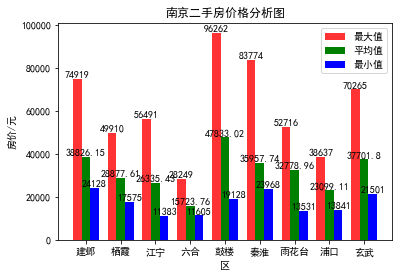

In [3]:

import json
import matplotlib.pyplot as plt
import matplotlib
plt.figure()
# 设置中文字体和负号正常显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
def load_data():
    global data,dic_data
    with open("nj.json","r",encoding="utf-8") as f:
        str = f.read()
        data = json.loads(str)
    dic_data = dict()
    for i in range(len(data)):
        per_price = (int)(data[i].get("price"))
        region = data[i].get("area")
        # print(per_price,region)
        try:
            dic_data[region].append(per_price)
        except:
            dic_data[region] = [per_price]
    print(dic_data)

def split_data():
    global region_data
    region_data = dict()
    for region in dic_data.keys():
        # 最大值、最小值、平均值
        region_data[region] = {"max":dic_data[region][0],"min":dic_data[region][0],"average":0}
        for per_price in dic_data[region]:
            if per_price > region_data[region]["max"]:
                region_data[region]["max"] = per_price
            if per_price < region_data[region]["min"]:
                region_data[region]["min"] = per_price
            region_data[region]["average"] += per_price
        region_data[region]["average"] /= len(dic_data[region])
        # 保留两位小数
        region_data[region]["average"] = round(region_data[region]["average"],2)
    print(region_data)

def data_viewer():
    label_list = region_data.keys()  # 横坐标刻度显示值
    max = []
    min = []
    average = []
    for label in label_list:
        max.append(region_data[label].get("max"))
        min.append(region_data[label].get("min"))
        average.append(region_data[label].get("average"))
    x = range(len(max))
    """
    绘制条形图
    left: 长条形中点横坐标
    height: 长条形高度
    width: 长条形宽度，默认值0.8
    label: 为后面设置legend准备
    """
    rects1 = plt.bar(x=x, height=max, width=0.25, alpha=0.8, color='red', label="最大值")
    rects2 = plt.bar(x=[i + 0.25 for i in x], height=average, width=0.25, color='green', label="平均值")
    rects3 = plt.bar(x=[i + 0.5 for i in x], height=min, width=0.25, color='blue', label="最小值")
    #plt.ylim(0, 50) # y轴取值范围
    plt.ylabel("房价/元")
    """
    设置x轴刻度显示值
    参数一：中点坐标
    参数二：显示值
    """
    plt.xticks([index + 0.25 for index in x], label_list)
    plt.xlabel("区")
    plt.title("南京二手房价格分析图")
    plt.legend() # 设置题注 # 编辑文本
    for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
    for rect in rects2:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height + 1, str(height), ha="center", va="bottom")
    for rect in rects3:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height + 1, str(height), ha="center", va="bottom")
    plt.show()

def main():
    load_data()
    split_data()
    data_viewer()

if __name__ == '__main__':
    main()
